In [4]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

env_1_sale_args['num_products'] = 10
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42
env_1_sale_args['mu_sale'] = True
env_1_sale_args['sigma_mu_sale'] = env_1_sale_args['sigma_mu_organic']/4

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# env_1_sale_args['number_of_flips'] = 5


1.966042202395077
mu sale [-2.43286871 -3.14117445 -3.95163555  1.71641825  0.98268564  1.05395866
 -4.5097286  -3.77018786 -0.1151348   1.52454295]
1.966042202395077
mu sale [-2.43286871 -3.14117445 -3.95163555  1.71641825  0.98268564  1.05395866
 -4.5097286  -3.77018786 -0.1151348   1.52454295]


## Build targets

In [2]:
## Clicks
from recogym.agents.sale_agent import ClickRewardProvider
Click_rewards = ClickRewardProvider()

## MDP
from recogym.agents.sale_agent import MDPRewardProvider, PostDisplayRewardProvider,DifferenceRewardProvider
# doesn't take into account the length of the observation
MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
# take into account length of the observation
MDP_rewards_time = MDPRewardProvider(clicks_only=True, organic_only=False, normalize = True)
MDP_rewards_all_time = MDPRewardProvider(clicks_only=False, organic_only=False, normalize = True)
MDP_rewards_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)
PostDisplay_rewards = PostDisplayRewardProvider()
# DifferenceRewardProvider = DifferenceRewardProvider(MDP_rewards_all_time,MDP_rewards_pureorganic,normalize = False)
# DifferenceRewardProvider_norm = DifferenceRewardProvider(MDP_rewards_all_time,MDP_rewards_pureorganic,normalize = True)

rewards = {'click':Click_rewards,
          'MDP':MDP_rewards,
          'MDP_all':MDP_rewards_all,
          'MDP_time':MDP_rewards_time,
          'MDP_all_time':MDP_rewards_all_time,
          'MDP_pureorganic':MDP_rewards_pureorganic,
          'PostDisplay':PostDisplay_rewards}

## Build features

In [3]:
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider, ShareViewsClicksFeatureProvider, ShareViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)
vc_share_feature = ShareViewsClicksFeatureProvider(env.config)
v_share_feature = ShareViewsFeatureProvider(env.config)

features = {'vc':vc_feature,
           'v':v_feature,
           'vc_share':vc_share_feature,
           'v_share':v_share_feature}

## Train baseline agents

In [4]:
# Choose number of users for training and AB test
env_1_sale_args['num_users'] = 50
env_1_sale_args['num_users_AB'] = 10
num_users = env_1_sale_args['num_users']
num_users_AB = env_1_sale_args['num_users_AB']

# Choose features
feature_name = 'v_share'
feature = features[feature_name]

In [5]:
from recogym.agents.sale_agent import build_train_data
from recogym.agents.sale_agent import SaleLikelihoodAgent, SaleProductLikelihoodAgent

agents={}
logs={}

############## Random agent
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))
name_agent = 'rand'
agents[name_agent] = random_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
# ############## Organic agent
# from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
# organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
#                                                                     **env_1_sale_args,
#                                                                     'select_randomly': True}))
# name_agent = 'organic'
# agents[name_agent] = organic_counter_agent
# try:
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except :
#     data = deepcopy(env).generate_logs(num_users,agent=organic_counter_agent)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data
    
# # ############## Likelihood click
# # name_agent = "likclick"
# # try :
# #     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# # except:
# #     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards)
# #     likelihood_logreg_click.train(data)
# #     agents[name_agent] = likelihood_logreg_click
# #     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
# #     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# # logs[name_agent] = data

# ############## Likelihood click kronecker
# name_agent = "likclickkron"
# try :
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except:
#     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,kronecker_features=True)
#     likelihood_logreg_click.train(data)
#     agents[name_agent] = likelihood_logreg_click
#     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

In [6]:
def train_timeagents(name_logging,logs,feature_name,features, kronecker_features=False, linear_reg=False):
    info = {}
    save_agents = {}
    data = logs[name_logging]
    feature = features[feature_name]
    
    name_extension = 'time'
    
    if kronecker_features==True:
        print("Kronecker features")
        name_extension += 'kron'
    if linear_reg ==True:
        print("Linear reg")
        name_extension += 'lin'
        
    
    # No discount
    print("No discount")
    likelihood_saleclickprod_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all_time], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod_all.train(data)
    info[likelihood_saleclickprod_all.info["Name"]] = likelihood_saleclickprod_all.info
    save_agents["likelihood_saleclickprod_all"+name_extension] = likelihood_saleclickprod_all
    
    # No discount
    likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_time], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod.train(data)
    info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info
    save_agents["likelihood_saleclickprod"+name_extension] = likelihood_saleclickprod
    
    # non-specific discount, all observations
    print("Non specific discount")
    likelihood_saleclickprod_discount_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all_time,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod_discount_all.train(data)
    info[likelihood_saleclickprod_discount_all.info["Name"]] = likelihood_saleclickprod_discount_all.info
    save_agents["likelihood_saleclickprod_discount_all"+name_extension] = likelihood_saleclickprod_discount_all
    
    # non-specific discount, clicked observations
    likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_time,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod_discount.train(data)
    info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info
    save_agents["likelihood_saleclickprod_discount"+name_extension] = likelihood_saleclickprod_discount
    
    # Per product discount, all observations
    print("Specific discount")
    likelihood_saleclickprod_discount_spe_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all_time,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod_discount_spe_all.train(data)
    info[likelihood_saleclickprod_discount_spe_all.info["Name"]] = likelihood_saleclickprod_discount_spe_all.info
    save_agents["likelihood_saleclickprod_discount_spe_all"+name_extension] = likelihood_saleclickprod_discount_spe_all
    
    # Per product discount, clicked observations
    likelihood_saleclickprod_discount_spe = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_time,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features,
                                                    linear_reg = linear_reg)
    likelihood_saleclickprod_discount_spe.train(data)
    info[likelihood_saleclickprod_discount_spe.info["Name"]] = likelihood_saleclickprod_discount_spe.info
    save_agents["likelihood_saleclickprod_discount_spe"+name_extension] = likelihood_saleclickprod_discount_spe
    
    pkl.dump([info,save_agents],open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'wb'))
    return info, save_agents

In [7]:
save_agents_sm = save_agents
del save_agents_sm[list(save_agents_sm.keys())[4]]
del save_agents_sm[list(save_agents_sm.keys())[4]]
save_agents_sm.keys()

NameError: name 'save_agents' is not defined

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [05:05<00:00,  3.06s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [05:14<00:00,  3.14s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.79s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:16<00:00,  3.77s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:25<00:00,  3.86s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:26<00:00,  3.87s/it]


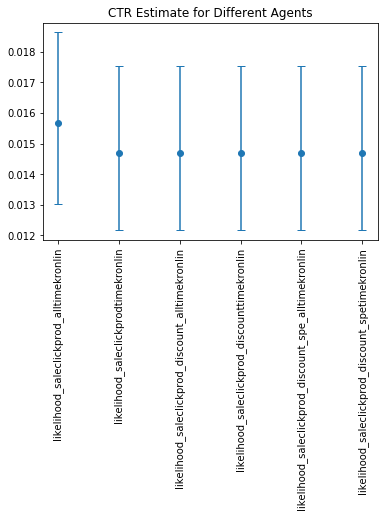

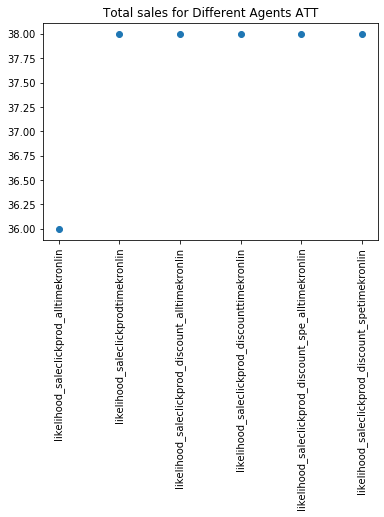

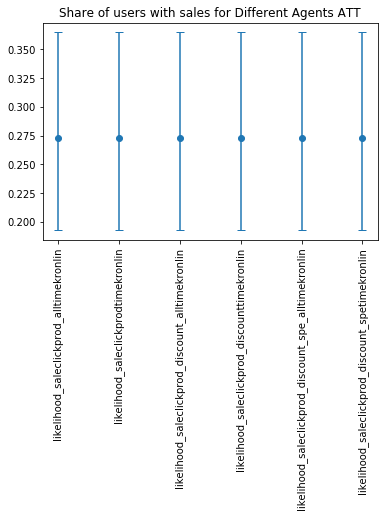

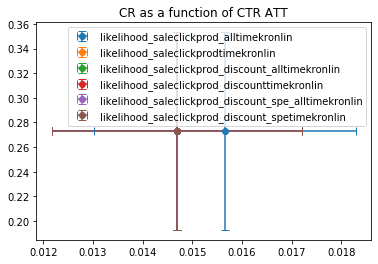

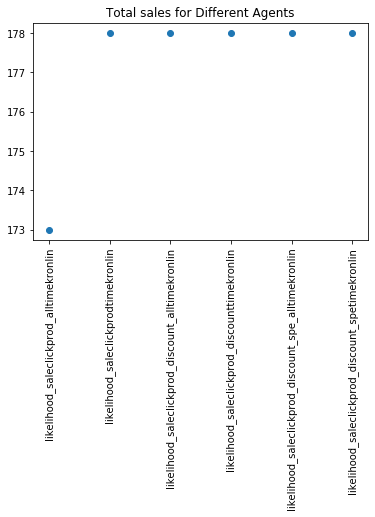

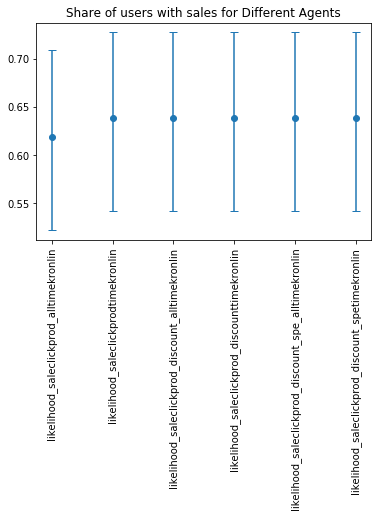

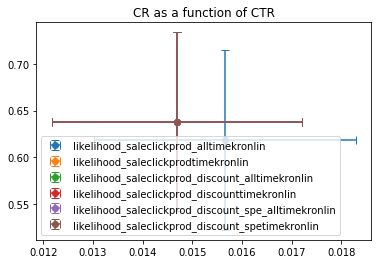

In [8]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=100,
    agents={
#         **agents, 
        **save_agents}
)

plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [05:42<00:00,  3.42s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:47<00:00,  4.07s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [08:00<00:00,  4.81s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:51<00:00,  4.11s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:52<00:00,  4.12s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [07:09<00:00,  4.30s/it]


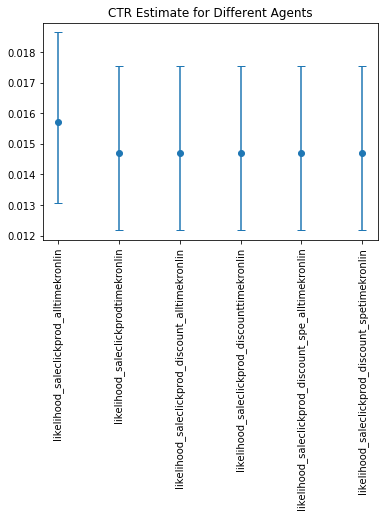

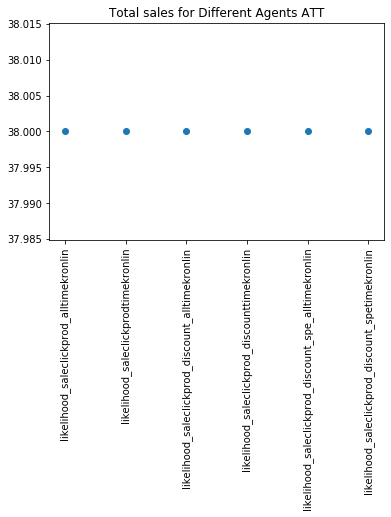

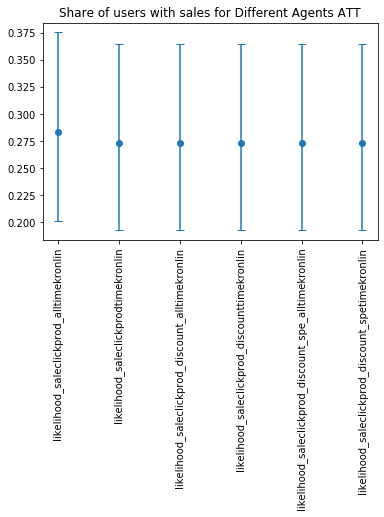

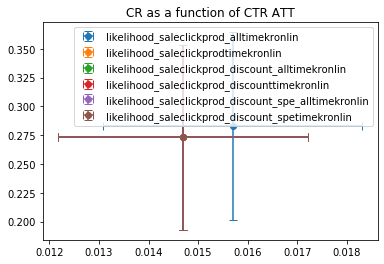

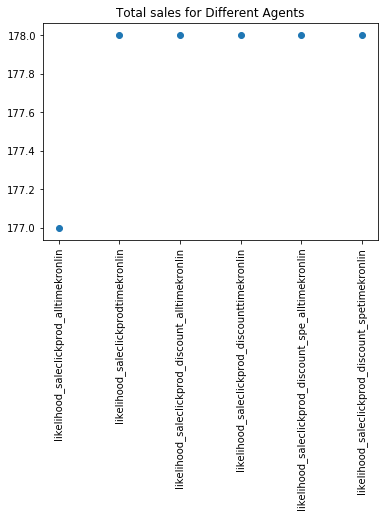

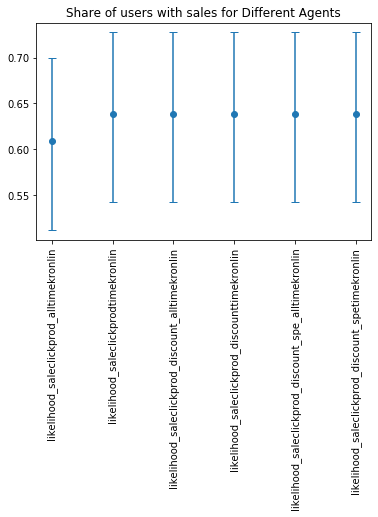

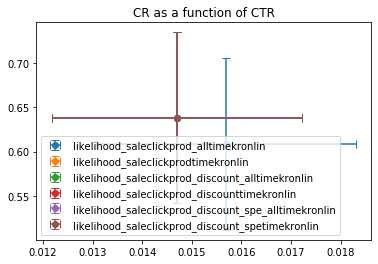

In [24]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=100,
    agents={
#         **agents, 
        **save_agents}
)

plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.30s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.90s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.09s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


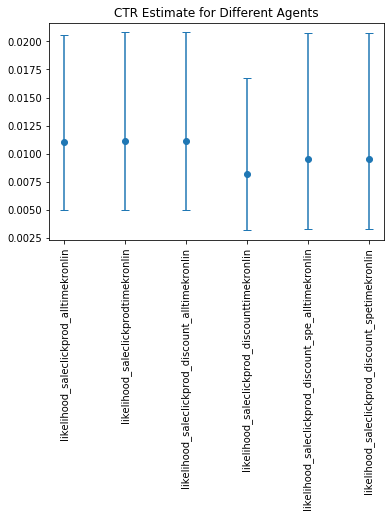

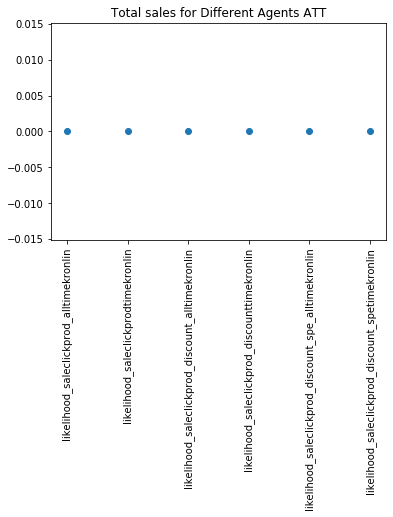

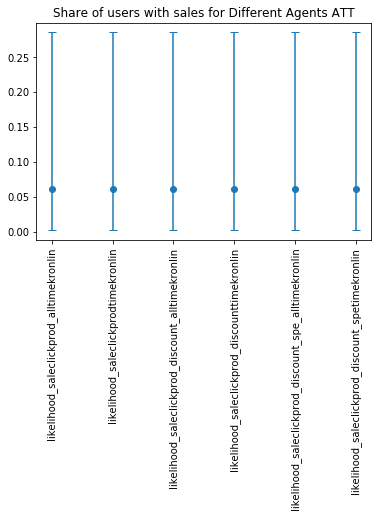

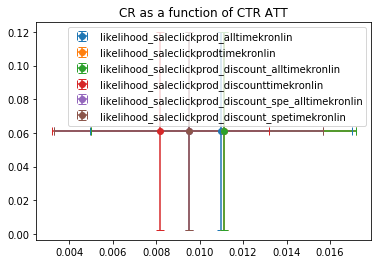

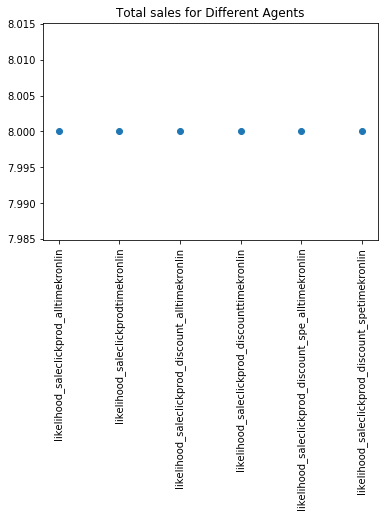

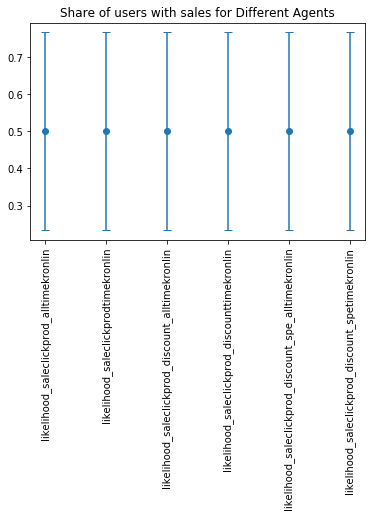

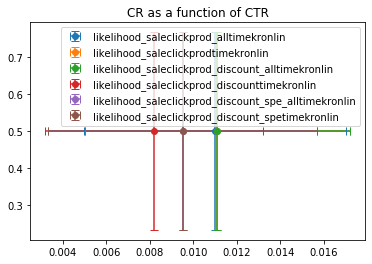

In [7]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

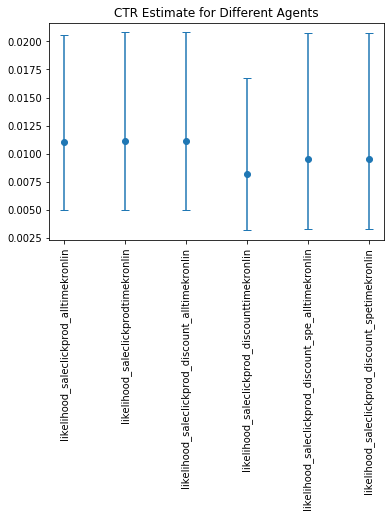

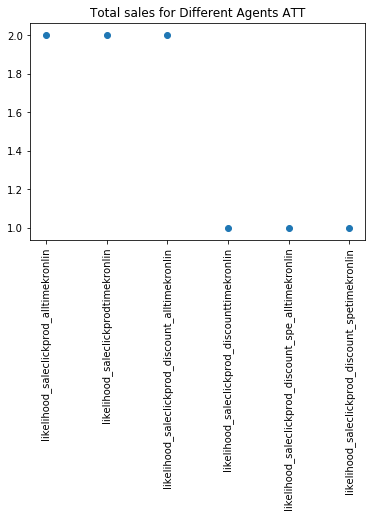

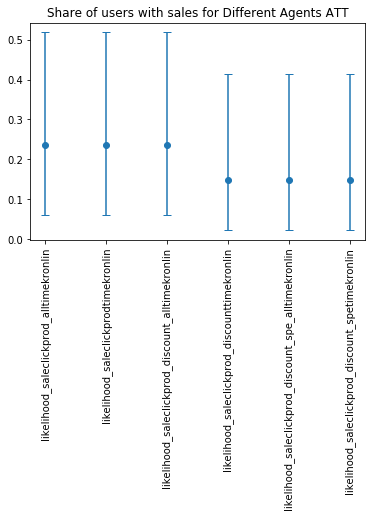

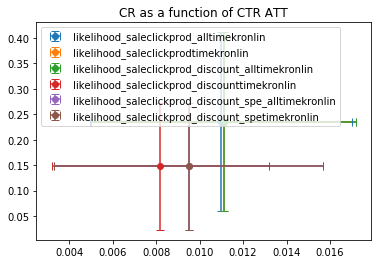

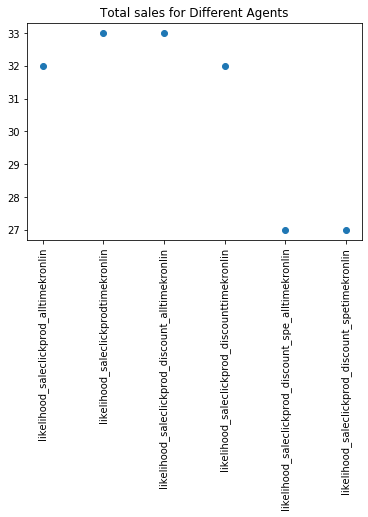

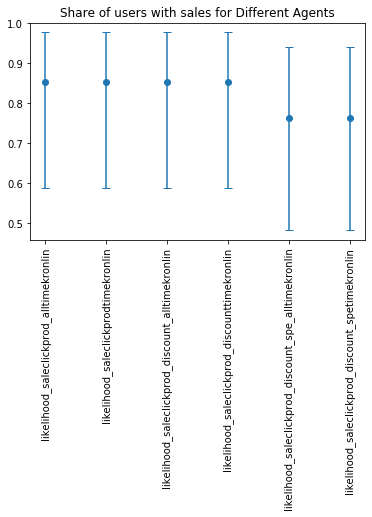

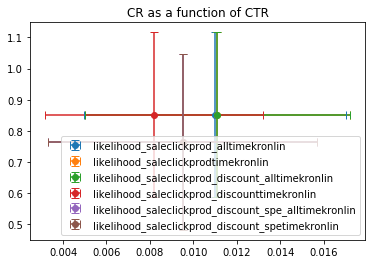

In [10]:

name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

In [7]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.646340742441154, -5.909899963071326, 3.6925816863431162, 2.3637340775777664, -4.607081705327143, -4.607081705327143, 1.6897603454701056, 1.6897603454701056]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, 11.98381111747469, 2.9994349170596735, 5.434491112732791, 11.546849792514513, 7.783361505313058, 9.62299947231354, 10.891896012394206, 7.911269848667404, 7.7204678536423526, 3.4549203977234524]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.761490909143692, -5.909899963071326, 3.6925816863431162, 2.3637340775777664, -4.607081705327143, -4.730083679452484, 1.6897603454701056, 1.6897603454701056]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, 11.98381111747469, 2.9994349170596735, 8.032396520836675, 11.546849792514513, 7.783361505313058, 11.674937715273002, 11.504739159674639, 8.734405812322192, 7.7204678536423526, 8.967596632673157]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.458370888676113e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discou

Users:  10%|███████▌                                                                    | 1/10 [00:00<00:06,  1.36it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.170705042805822e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1697006972996165e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.16902496306096e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1683494064335335e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1676740273561945e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.166998825767837e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.166323801607335e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.16564895481363e-11

Users:  20%|███████████████▏                                                            | 2/10 [00:01<00:05,  1.43it/s]

[1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.160032154831154e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.163854022985073e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.169811728704765e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.175776760166565e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1817491247846734e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.187728829978994e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.193715883175103e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.199710291804302e-11
before discount 

Users:  30%|██████████████████████▊                                                     | 3/10 [00:02<00:05,  1.19it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2974445050745665e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.3016355645279744e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.3055949291206684e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.3095547738229274e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.313515097048626e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.317475897213509e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.320892487144373e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.324038198523281e-11
before disco

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8509008642172692e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.80631093404818e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7625350945186677e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.719556516528725e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6813374820431996e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6457332974949572e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.610714726958583e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.5762704727640205e

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:05<00:09,  1.63s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0749096371343056e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0513329342315734e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0281030761513012e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0097941326027326e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9939378368284517e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9782080810738728e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.962603844059024e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.94712411283824

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:07<00:08,  1.65s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.1974957604659814e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.8972169811632745e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.609945790717236e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.335098388953438e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.0721180715439436e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.988660427080129e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.991147820649645e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.993636024602017e-

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.037894939495489e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.038552800526761e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.039209455043931e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.039864906359203e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.040519157772694e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.041172212572466e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.0370962807979586e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.030672804411026e-12

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:11<00:08,  2.23s/it]


before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.900218150142506e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.8942103888474195e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.888220592449102e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.890408609951947e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.896682439907581e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.90295971769619e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.909240442604643e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.915524613918901e-12

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.710267162766738e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.688919075132788e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.66770086481392e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.646611456306018e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.6256497852171354e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.604814798130686e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.5841054524709716e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.5635207163703166e-1

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:15<00:08,  2.68s/it]

[1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.194419695481007e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.224048924018176e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.2755353959769e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.3274073367095785e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.379667314088804e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.4323179108344765e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.490985164126039e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.552975510432228e-12
before discount  

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.5301139849246563e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.5551861171149086e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.580627080859035e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6064416514740608e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6326346570820148e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6592109790838588e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6861755526364672e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.71353336713279

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:18<00:05,  2.84s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1238196184389016e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1363487514926314e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1366555292822245e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1369623286788612e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.137269149681674e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1375759922897723e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1378828565022814e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.138189742318327e-11
before dis

Users:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:18<00:02,  2.10s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1451398959363225e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1433762489866573e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.141614438097985e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1398544609993788e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1380963154231135e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.136339999104712e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1345855097828962e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.132832845199602

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0824687696701896e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0818021914093204e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0811361146877564e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0804705389737287e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0798054637361806e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.079140888444797e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0784768125699507e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.07781323558276

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1402003747142243e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.141564024724373e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1429270193975624e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1442893589304066e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1456510435202016e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.147012073364959e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.148372448663354e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1497321696147395

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.97s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]


discount_val  2.1549114363136475e-11
Min dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.761490909143692, -5.909899963071326, 3.6925816863431162, 2.3637340775777664, -4.607081705327143, -4.730083679452484, 1.6897603454701056, 1.6897603454701056]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, 11.98381111747469, 2.9994349170596735, 8.032396520836675, 11.546849792514513, 7.783361505313058, 11.674937715273002, 11.504739159674639, 8.734405812322192, 7.7204678536423526, 8.967596632673157]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.338253204603458e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-

Users:  10%|███████▌                                                                    | 1/10 [00:00<00:06,  1.49it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.112809625033885e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.112511724465333e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.112214164897021e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.111916945744535e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.111620066424848e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.113663048803618e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1144085509518785e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.113921034450466e-12

Users:  20%|███████████████▏                                                            | 2/10 [00:01<00:05,  1.51it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1161571485073704e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.120236061440555e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.125950492677717e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.131672085532568e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1374008479723955e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.14313678797218e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.148879913514495e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.15463023258969e-12
before discount 

Users:  30%|██████████████████████▊                                                     | 3/10 [00:02<00:05,  1.21it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.279270805538017e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.282965967658015e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2861751126846e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.289386235819357e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2925993379904516e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.272997303991619e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2421786249130956e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.211588290927783e-12
before discount 

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8476033868216538e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8120499726544025e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7791086397923993e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7466239745416007e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7145887451882513e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6829958480032924e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6518383047492583e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6211092602399

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:06<00:09,  1.65s/it]

 2.1940947126102867e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.175729424701458e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1593647588276284e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1431241967426555e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.12700678960343e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1110115958797904e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.095137681297712e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0820144697091384e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:07<00:08,  1.68s/it]


discount_val  7.223798980830533e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.934683837830628e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.842826044925682e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.845596569287354e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.848368044306494e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.851140470245286e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.853913847366014e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.856688175931047e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.536482905942387e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.564811132673388e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.593209353560241e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.621677628248194e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.650216016204309e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.678824576717433e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.707503368898124e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.736252451678636e-13


Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:11<00:09,  2.26s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.205844694668739e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.23579756130256e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.26582174878273e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.295917312647042e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.311455873267022e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.319696456885041e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.327942238607332e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.336193219304097e-13
before discount  [

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.416194893651975e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.385016670591504e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.354006130472519e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.3231620926578e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.292483386645327e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.261968851966464e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.231617338085107e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.201427704298192e-13
be

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:15<00:08,  2.72s/it]

discount_val  8.662062639497405e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.64097493941174e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.6199926534177e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.660335965512384e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.731761482261483e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.80373566508231e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.876262407193941e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.949345627062408e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
disc

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1819128454034276e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2183844353743775e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2554211340358927e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2930309822751675e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.3312221247598105e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.3700028111322344e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.409381397216072e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.44936634623456

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:18<00:05,  2.90s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9504355561307597e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0037638772081743e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0220434646920204e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.022504796760828e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0229661745435278e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.023427598041564e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.023889067256336e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.024350582189266e-12
before disco

Users:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:18<00:02,  2.15s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0356461978054314e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0353833394708182e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.032899019303581e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.030417130693448e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0279376709027656e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0254606371973148e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.022986026846367e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0205138371226172e-12
before disc

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9547226701408956e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9539065886979735e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9530909920035582e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.952275879656919e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9514612512577826e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.950647106406278e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9498334447029257e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.949020265748722

discount_val  3.061172056952096e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.063647726810748e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.066123346447516e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.068598915056334e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0710744318325723e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0735498959730044e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.076025306675787e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0785006631404695e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-1

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.96s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.114063622631684e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1138285839862432e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1135938001234188e-12
Min dot product


Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

 [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.761490909143692, -5.909899963071326, 3.6925816863431162, -3.8069296737872644, -4.607081705327143, -4.730083679452484, 1.6897603454701056, 1.6897603454701056]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, 11.98381111747469, 2.9994349170596735, 8.032396520836675, 11.546849792514513, 7.783361505313058, 9.2878219453442, 11.504739159674639, 8.734405812322192, 7.7204678536423526, 8.967596632673157]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.082926552006868e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.0592427

Users:  10%|███████▌                                                                    | 1/10 [00:00<00:06,  1.45it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.819123235159031e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.818482869498244e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.817843102884324e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.817203934482762e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.819038342525937e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.819670568080134e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.819083849347985e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.818497231437277e-13


Users:  20%|███████████████▏                                                            | 2/10 [00:01<00:05,  1.53it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.820296316539906e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.821210083443409e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.826145632207376e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.833099912582866e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.840063516746896e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8470364562309e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.854018742579292e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.861010387349444e-13
be

Users:  30%|██████████████████████▊                                                     | 3/10 [00:02<00:05,  1.21it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.995114797900864e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.001302450445652e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.007291626043367e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.013285580862871e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.01928431633264e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.025287833879892e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.029905168305837e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.033830041512199e-13
before discount  

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.4588054929366515e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.410537967565515e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.363008567430345e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.321404731362947e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.282949568473042e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2450021633892574e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.207555039795606e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.170600842277127e-1

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:05<00:09,  1.62s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.649073429239017e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.622458060572569e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.596156515968e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.5742554696745283e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.554578149376375e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.5350521708606204e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.5156763629963346e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.496449563770183e-13
before discount 

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:07<00:08,  1.65s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.712634894704735e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.355150483813542e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.012634671998639e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.903852258601831e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.907114946606401e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.9103788275006e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.913643901660735e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.916910169462983e-14
before discount  [

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.614297977435201e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.646191189662499e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.678170963866378e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.710237434103986e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.742390734406227e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.774630998777648e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.80695836119555e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.839372955610233e-14
b

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:11<00:09,  2.25s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.540466944866989e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.57483447252317e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.592414561237814e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.60157601125707e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.610743670041993e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.619917539727305e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.629097622447069e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.638283920334931e-14
before discount  [

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0793028207286945e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0753175561069013e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0713533955641877e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0674101987301634e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.063487826344824e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0595861402484533e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0557050033716004e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.05184427972516

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:15<00:08,  2.78s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.900731654962319e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.957724830156732e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0045769964724377e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0134554621030403e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0224084675016449e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0314366046568562e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0415094340202629e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0541248516429845e-13
before dis

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:15<00:04,  2.13s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1910586975841697e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1936090741235355e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.196164355145975e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1987245489525729e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2012896638564134e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2038597081825698e-13


Users:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:16<00:01,  1.60s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2064346902681423e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2090146184622824e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2115995011261673e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2141893466330528e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2153543954407512e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.215805512602109e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2162567775896939e-13
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.21670819044507

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2776529589496832e-13
Min dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.761490909143692, -5.909899963071326, 3.6925816863431162, -3.8069296737872644, -5.380686640835507, -8.972584927951281, 7.135489960752345, -5.878648940192238]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, 11.98381111747469, 2.9994349170596735, 8.032396520836675, 11.546849792514513, 7.783361505313058, 9.2878219453442, 10.891896012394206, 7.662909775219228, 7.135489960752345, 7.135489960752345]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_

Users:  10%|███████▌                                                                    | 1/10 [00:00<00:06,  1.32it/s]


discount_val  1.6482639175490803e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.650434120861606e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.651269313854629e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6511222140960976e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6509751337786126e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6508280728988853e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6506810314536624e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.650534009439662e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.

Users:  20%|███████████████▏                                                            | 2/10 [00:01<00:05,  1.34it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6540752364372304e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.654970934561423e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.655866770614509e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6567627444971392e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6587940149118718e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.66139609823269e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6640020389956846e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6666118425771144e-14
before disco

Users:  30%|██████████████████████▊                                                     | 3/10 [00:02<00:06,  1.06it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8216679389994213e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8298750914889673e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8381163853561035e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.841956033675986e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8435845277577303e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.845214321796149e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8468454167113367e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.838237883971262

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2612613008260632e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2439593331143709e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.229086385419978e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2154849791703567e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2020531949154822e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1887886931771146e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1756891696957362e-14
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.16275235485763

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:07<00:11,  1.98s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.902637806376264e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.809040648081025e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.716469506684713e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.634106112367583e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.557028135050255e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.480569974764513e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.40472662201494e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.329493107997664e-15
b

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:09<00:10,  2.01s/it]

3.2709540142744764e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.131231600898683e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9975792767005887e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8697289598130297e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.829223705832783e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8305243220562015e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8318254829804417e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8331271888102365e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.133080128526015e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.146944024552241e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1608573711914225e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1748202973812746e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1888329322443235e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.202895405088094e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2170078454047773e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2311703828711416

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:14<00:11,  2.85s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5099508706701938e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5251428667245227e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5403877256143995e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5482186987827337e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5523282119979533e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.556441493584025e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.560558545968646e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.564679371580088

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1132553118430545e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.100860213582415e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.0885197908435775e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.076233738330206e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.0640017527831615e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.051823532964776e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.039698779643348e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.027627195577569e-

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:18<00:09,  3.30s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.894038087091487e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.919687671822669e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.957201075156122e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.995058950304926e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.033264324112002e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.071820248792047e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1148384520600715e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.168687610114021e-15

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:19<00:05,  2.51s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.661591422053818e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.727021016485845e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.756653886343741e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.768115305576801e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.7796021499707745e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.791114470857567e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.802652319661909e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8142157479015696e-1

Users:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:19<00:01,  1.88s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.860726288832176e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.865976031508108e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.868009548473703e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8700438377728586e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8720788996679735e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8741147344215636e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8761513422962194e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8781887235545764

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.111050604665266e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.122710555428885e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.1371114668277656e-15
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.152910930825195e-15
Min dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.1951733659750925, 11.98381111747469, 5.1951733659750925, 11.98381111747469, -1.2172871795935483, -4.786390893235858, -4.1332527725129955, -5.909899963071326, 3.6925816863431162, -3.8069296737872644, -5.380686640835507, -8.972584927951281, 7.135489960752345, -5.878648940192238]
Max dot product [5.1951733659750925, 11.98381111747469, 11.98381111747469, 5.1951733659750925, 3.712456422465761, 5.19517

In [8]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.24356199]), array([-0.24356199]), array([-2.51281426]), array([-0.24356199]), array([3.07683573])]
Max dot product [array([0.76680637]), array([-2.2266157]), array([0.76680637]), array([0.46069338]), array([0.76680637]), array([-1.92572503]), array([0.76680637]), array([-2.2266157]), array([-1.32215305]), array([0.46069338]), array([0.46069338]), array([0.46069338]), array([0.46069338]), array([0.46069338]), array([0.46069338]), array([-1.92572503]), array([0.46069338]), array([0.46069338]), array([0.76680637]), array([0.76680637]), array([-1.92572503]), array([-0.70934488]), array([-0.1521816]), array([-0.42069941]), array([-0.1521816]), array([-0.1521816]), array([-0.1521816])

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.25715857]), array([-0.89189493]), array([-2.67100396]), array([-0.89189493]), array([3.07683573])]
Max dot product [array([1.7431989]), array([-1.43708104])]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.12s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.25715857]), array([-0.89189493]), array([-2.67100396]), array([-0.89189493]), array([3.07683573])]
Max dot product [array([1.7431989]), array([-1.43708104])]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.25715857]), array([-0.89189493]), array([-2.67100396]), array([-0.89189493]), array([3.07683573])]
Max dot product [array([1.7431989]), array([-1.43708104])]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.45s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.25715857]), array([-0.89189493]), array([-2.67100396]), array([-0.89189493]), array([3.07683573])]
Max dot product [array([1.7431989]), array([-1.43708104])]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.24s/it]

Min dot product [array([-3.49267413]), array([-0.73992443]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-3.49267413]), array([-0.73992443]), array([-0.73992443]), array([-0.73992443]), array([-0.25715857]), array([-0.89189493]), array([-2.67100396]), array([-0.89189493]), array([3.07683573])]
Max dot product [array([1.7431989]), array([-1.43708104])]


In [15]:
name_extension = 'timekronlin'
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

Kronecker features
Linear reg
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.01s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9401093890908447e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9428292964309935e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9455514917528023e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9488777608407008e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9525087603128776e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.956143907972443e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.95978320

Users:  10%|███████▌                                                                    | 1/10 [00:02<00:18,  2.08s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0122640087416915e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0063265911464506e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.000419920606947e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.000006618748796e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0023319087516496e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0046597225727867e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.006496195

Users:  20%|███████████████▏                                                            | 2/10 [00:03<00:14,  1.82s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.043308698033729e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0449199981034165e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.043498646714112e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0405679399315977e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0376459250999546e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.034732566595082e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0318278289

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8968498056213948e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8943417122509207e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.891840624476912e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8893465151619593e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8868593573013773e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.884379124022379e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.881905788

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.898289070732725e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.901852948386481e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9015211240531552e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.899249344235505e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8969860964939054e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8947313344526717e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8924850120

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7309421639171447e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.772588600441042e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.81472552571498e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.857356777811605e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.900486204991156e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.944117665583506e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9882550278697

Users:  30%|██████████████████████▊                                                     | 3/10 [00:14<00:31,  4.49s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1237413544797976e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.1281777290697986e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.11189313400453e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.095696378571902e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.079586972721239e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0635644292249293e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.04762826366

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.742273223615259e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.7074745617278633e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6734232413528778e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6401021321979652e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6074945205843928e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.575584098748485e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.544354954

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:17<00:24,  4.10s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1706295569715052e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1631803574993862e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1634259983265967e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1636716009912675e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1639171654968121e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1641626918466648e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1644081800442586e-10
[0

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1651674852957386e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1656420472469054e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.166115902751879e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1665890533478917e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1670615005678638e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1675332459404288e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.16353334

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:21<00:20,  4.07s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.865566845837315e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.81430215460063e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.831647113373997e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.883364827061523e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.93532498988112e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.987528591360126e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0039976624415328e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.009855382569513

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6151723871244246e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6324765213880672e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6499446576439275e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.667578134944998e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6853783013664403e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.7033465140517416e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.72148413

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:24<00:15,  3.93s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1847832146453782e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.184878312326766e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1849734089753885e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1850685045911771e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1851635991740488e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1852586927239345e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.18535378

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:25<00:08,  2.89s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1879658714384698e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1871320409977192e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.185381031819617e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1836317095551269e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1818840723277446e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.180138118263324e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.178393845

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.104283457033361e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1029934814089745e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.101704713216039e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.100417151001925e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0991307933160756e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0978456387100663e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0965616857

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.040542038255294e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0395787346325807e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.038616700952249e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0376559348115152e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.036696433813468e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0357381955670637e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.0347812176

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.962185211610803e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9595977210389408e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9570163070891499e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9544409506153365e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9518716325460588e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9493083338841765e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.94675103

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:38<00:11,  5.86s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9165247067996234e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9147121601654368e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9143330377015897e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9145027336685976e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9146724273154898e-10
[0 1 2 3 4 5 6 7 8 9]


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.84s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.91484211864165e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.915011807646462e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.915181494329304e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.9142121532402276e-10
[0 1 2 3 4 5 6 7 8 9]



Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.286609552472481e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.299824490684696e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.313053495566729e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.328903662297603e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.346079458313467e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.363278959613474e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.38050218617578e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.397749157980182e-11
b

Users:  10%|███████▌                                                                    | 1/10 [00:01<00:16,  1.87s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.686558294450277e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.685803959721481e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.695956422752022e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.706119019470397e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.714122638334456e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.721046634084098e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.727974526629555e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.734906317501942e-11
before discount 

Users:  20%|███████████████▏                                                            | 2/10 [00:02<00:12,  1.60s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.853344691209397e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.860346914077815e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.867353064413868e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.874363143753922e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.881377153634753e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.874846132434545e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.861567234615107e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.848319389782457e-11


before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.083787957731819e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.072315673770217e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.060868929066544e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.049447647525971e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.038051753333725e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.026681170954075e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.015335825128993e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.004015640877e-11
bef

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.122442569013975e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.12145033896847e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.120460082904859e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.119471794944113e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.118485469230572e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.11750109993172e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.116518681238078e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.115538207363154e-11
be

Users:  30%|██████████████████████▊                                                     | 3/10 [00:13<00:30,  4.42s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0711535431878002e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0812612110962251e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0810357345896134e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0756429430169368e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0702777558500761e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0649400282408649e-10
[0 1 2 3 4 5 6 7 8 9]
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0596296

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.597246228443419e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.489941027398941e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.3848050403375206e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.281792214251905e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.1808575194297486e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.0819569257260514e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.9850473794079626e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8900867805581586

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:17<00:25,  4.22s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.195809882239246e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.16980849627943e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.170655959282805e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.171503377427367e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.172350750699185e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.173198079084323e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1740453625689134e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.174892601139042e-11


before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.0677723314641087e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.046709228842248e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.02578636683549e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.00500262780063e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.984356904371113e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.963848099350503e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.943475125607254e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.9232369059706e-11
bef

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:21<00:21,  4.20s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.602484624019861e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.583585966604217e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5648215189734254e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.546190112393814e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.52769059005647e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.533802544033015e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.5522502556318615e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.570786732278551e-11

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.257244423076651e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.324403802706695e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.392224476547194e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.460712344778679e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.529873354474541e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.599713499924689e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.67023882296132e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.741455413286212e-11
b

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:25<00:15,  3.99s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.763499865012354e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.852595042092541e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.882750787346981e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.883128680124484e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.883506576163908e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.883884475464822e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.88426237802683e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.884640283849586e-11
before discount  

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:25<00:08,  2.90s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.887898714686842e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.891464197096474e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.89528234079662e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.892422956797649e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.886166317139097e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.879915373724544e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.873670120741008e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.867430552382126e-11
before discount  

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.56003516071397e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.555631973871456e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.551232380900806e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.546836378149274e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.542443961968453e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.538055128714366e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.533669874747409e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.529288196432316e-11
b

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.342325038007572e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.33956816531261e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.336814015788342e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.334062585595595e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.331313870902238e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.32856786788301e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.325824572719613e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.32308398160062e-11
bef

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:36<00:10,  5.33s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.988061246274899e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.98666506308275e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.987337399816713e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.988009750699583e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.98868211572868e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.989354494901373e-11
before discount 

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.69s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.990026888214958e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.98645252731808e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.09004205452595e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.094123019717941e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.098208299265397e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.10319392368228e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.108634688744013e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.114083149500133e-11
before discount  [1

Users:  10%|███████▌                                                                    | 1/10 [00:01<00:14,  1.63s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2327785834485174e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2252291603688666e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.217705431490755e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2102072862778406e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2100148303839006e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.213469709307767e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2169281788399783e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2196718873769384e-11
before dis

Users:  20%|███████████████▏                                                            | 2/10 [00:02<00:11,  1.42s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.275314494349182e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.271039786873255e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.2667738025482955e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.262516518321775e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.258267911215044e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.254027958322966e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.249796636813704e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.245573923928358e-11

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9959539826079116e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.992238025506333e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9885293420728484e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.9848279138157484e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.981133722300438e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.977742144158328e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.974505018112166e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.971274538991609e-

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.067169672386929e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.06788424839477e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0685979793823215e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.069310866828324e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0700229122081445e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.0707341169937826e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.071444482653788e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.072154010653437e-1

Users:  30%|██████████████████████▊                                                     | 3/10 [00:13<00:29,  4.20s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.6817943287898335e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.719400409731825e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.719343518168779e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.700431875698787e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.6816182744746735e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.662902196574008e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.644283126861012e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  3.625760552971207e-1

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.8265902774585117e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.7907974677529183e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.755734669344592e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.7213864217617114e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.687737603829096e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6547734259661656e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.6224794226654566e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.590841445147281

Users:  40%|██████████████████████████████▍                                             | 4/10 [00:16<00:23,  3.98s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4140359245712332e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4050104545842836e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4052739841642052e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4055375112882805e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4058010359519196e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4060645581505249e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.406328077879507e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.4065915951342647e-11
before di

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.342914310738842e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.335649648327236e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.3284325879625804e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.3212627681937453e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.3141398306684387e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.3070634201037568e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.3000331842570015e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.293048773896803

Users:  50%|██████████████████████████████████████                                      | 5/10 [00:20<00:19,  3.98s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1876703975862029e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1810719452488596e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1745196490362024e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.176733509271288e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1833442299773218e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.189989986922792e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1966709543311908e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.203387307233428e-11
before disc

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.1827769960661202e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2082355094724735e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2339732961294443e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2599932200688816e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.2862981725757556e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.3128910724264574e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.3397748661290484e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.3669525281653

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:25<00:16,  4.15s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.7950090213542926e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8067336925623413e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8068736519128678e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8070136139353765e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8071535786297408e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.807293545995883e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8074335160336975e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.807573488743097e-11
before dis

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:25<00:09,  3.08s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8086550973134065e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8099978523636695e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8114343344616975e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8103822105500087e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8080640792515418e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8057480736747322e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8034341916842966e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.8011224311472

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6919346993309944e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6903268392652683e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6887202343784826e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6871148834877344e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6855107854114028e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.683907938969179e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.682306342982053e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.680705996272262

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6133924423071975e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6124219942036294e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.611452374525065e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6104835822778995e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6095156164700534e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.6085484761109585e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.607582160211549e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.606616667784273

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:38<00:11,  5.83s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.484145787081856e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.481706522986675e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.4811807710782237e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.4814287788219587e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.4816767966166012e-11


Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.84s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.481924824461515e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.482172862356072e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.4824209102996453e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  2.4810705379373388e-11



Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0533337583279045e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0547867650053964e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0562414733372166e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0579964978641356e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0599035489924423e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0618135267192307e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0637264346837903e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0656422765287

Users:  10%|███████▌                                                                    | 1/10 [00:01<00:17,  1.99s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1086172628544873e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1064306153572313e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1042501337075133e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1042851190216734e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1054267429710266e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1065695136433802e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1074831547001216e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1082822701312252e-11
before d

Users:  20%|███████████████▏                                                            | 2/10 [00:03<00:14,  1.77s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1251810705809493e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1259913878524406e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1268022174588951e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1261880963320821e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1248632762316432e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1235407881538072e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1222206268592257e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.1209027871226731e-11
before d

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0435222147412272e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.04234068622731e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0411611723521421e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0399836687214591e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0388081709525205e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0376346746740818e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0364631755263614e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.035293669160995

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.067835956749731e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.068147220739135e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0684582202877316e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.068768955719203e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0690794273567323e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.069389635523027e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0696995805402706e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.0700092627301764e

Users:  30%|██████████████████████▊                                                     | 3/10 [00:13<00:31,  4.43s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2965546557928041e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2966243280525239e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2901669330043555e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2837422168260813e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2773500115298491e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.2709901500047027e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.264662466011868e-11
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  1.25836679418020

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.33439123609541e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.212491299733315e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  6.093016363926545e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.975916640852355e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.861143396111574e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.7486489257896165e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.638386534030536e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.530310511113152e-12


Users:  40%|██████████████████████████████▍                                             | 4/10 [00:16<00:24,  4.02s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.320539535467182e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.218757903448042e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.118989241172331e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  5.021192457498639e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.989653492866492e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.990596633740616e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.991539802094058e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.992482997911168e-12


before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.882011120453394e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.8559180137345875e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.829988745270915e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.804222144938237e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.778617051925768e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.753172314654655e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.727886790697401e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.70275934669788e-12


Users:  50%|██████████████████████████████████████                                      | 5/10 [00:20<00:19,  3.89s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.209893039205623e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.186771718651673e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.1945228623980575e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2177605437878525e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.2411209187629965e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.264604602463456e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.288212212944937e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  4.314593555618254e-12
before discou

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.818313517537962e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  7.908770816441337e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.000223232422833e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.092681132636832e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.186154986030233e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.280655364278919e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.376192942732148e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.47277850136536e-12
b

Users:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:23<00:14,  3.72s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.759696454996655e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.88153522633996e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.922811053726753e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.923327827090729e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.92384461430102e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.924361415357442e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.924878230259918e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.925395059008232e-12
before discount  [

Users:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:24<00:08,  2.72s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.940014144499393e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.936419528614805e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.928323447341223e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.920234575732262e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.91215290684495e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.904078433743581e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.896011149499458e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.887951047191175e-12
b

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.533085448636759e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.527552258880941e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.522023115294391e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.516498014371159e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.510976952608756e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.505459926508112e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.499946932573852e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.494437967313771e-12


before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.279153906225095e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.276110603201061e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.273069509165234e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.27003062187674e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.266993939097472e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.263959458592358e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.260927178129016e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  9.257897095478123e-12
b

Users:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:34<00:10,  5.09s/it]

before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.848248974089606e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.837367955252811e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.8288154399219e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.826964022516582e-12
before discount 

Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.51s/it]

 [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.827882598047956e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.828801224039314e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.829719900489928e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.83063862739886e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.831557404765388e-12
before discount  [1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10]
discount_val  8.82679540007197e-12


In [16]:
def sig(x):
    return 1.0 / (1.0 + np.exp(-x))


def flatsig(x,coef=1):
    return 1.0 / (1.0 + np.exp(-coef*x))


def ff(xx, aa=5, bb=2, cc=0.3, dd=2, ee=6):
    # Magic numbers give a reasonable ctr of around 2%.
    return sig(aa * sig(bb * sig(cc * xx) - dd) - ee)

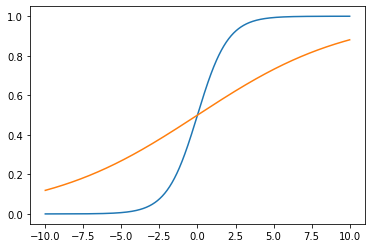

In [25]:
seq = np.linspace(-10,10,1000)
plt.plot(seq,sig(seq),label="sig")
plt.plot(seq,flatsig(seq,coef=0.2),label="flatsig")
plt.show()

In [39]:
per_user_discount = np.array(data.groupby(["u"]).mean()["r"])
data["r"] = (data["r"]>0)*1
reward_model = data
reward_model["r"] = reward_model["r"]- per_user_discount[reward_model["u"].astype(int)]
reward_model

,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,4,<NA>,NaN,0.0,NaN,None
1,1.0,0,organic,3,<NA>,NaN,0.0,NaN,None
2,2.0,0,organic,1,<NA>,NaN,0.0,NaN,None
3,3.0,0,organic,1,<NA>,NaN,0.0,NaN,None
4,4.0,0,organic,7,<NA>,NaN,0.0,NaN,None
...,...,...,...,...,...,...,...,...,...
1562077,1.0,14999,organic,4,<NA>,NaN,0.0,NaN,None
1562078,2.0,14999,bandit,<NA>,1,0.0,0.0,0.1,()
1562079,3.0,14999,bandit,<NA>,1,0.0,0.0,0.1,()
1562080,4.0,14999,bandit,<NA>,3,0.0,0.0,0.1,()


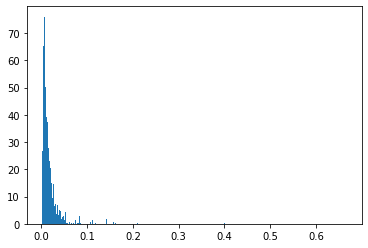

In [66]:
plt.hist(per_user_discount[per_user_discount>0],
         bins=len(np.unique(per_user_discount[per_user_discount>0])),density=True)
plt.show()

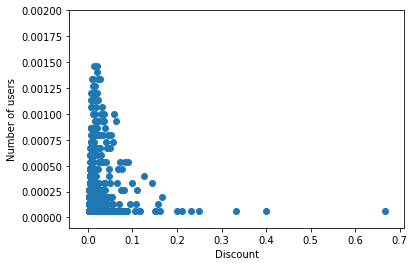

In [59]:
discounts_,nb_ = np.unique(per_user_discount[per_user_discount>0], return_counts = True)
nb_ = nb_/len(per_user_discount)
plt.scatter(discounts_,nb_)
plt.ylim(-0.0001,0.002)
plt.xlabel("Discount")
plt.ylabel("Number of users")
plt.show()

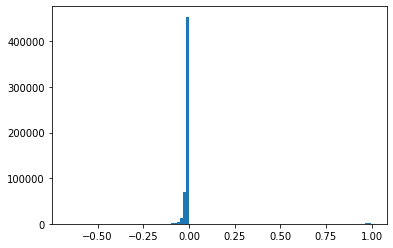

In [69]:
plt.hist((reward_model['r'][reward_model['r']>-1][reward_model['r']!=0]),bins=100)
plt.show()

## Random logging policy

In [37]:
def train_agents(name_logging,logs,feature_name,features, kronecker_features=False):
    info = {}
    save_agents = {}
    data = logs[name_logging]
    feature = features[feature_name]
    
    if kronecker_features==True:
        print("Kronecker features")
        name_extension = 'kron'
    else:
        name_extension = ''
    
    # click agent
    print("Click agent")
    likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,
                                                 kronecker_features = kronecker_features)
    likelihood_logreg_click.train(data)
    info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info
    save_agents["likelihood_logreg_click"+name_extension] = likelihood_logreg_click
    
    # No discount
    print("No discount")
    likelihood_saleclickprod_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_all.train(data)
    info[likelihood_saleclickprod_all.info["Name"]] = likelihood_saleclickprod_all.info
    save_agents["likelihood_saleclickprod_all"+name_extension] = likelihood_saleclickprod_all
    
    # No discount
    likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod.train(data)
    info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info
    save_agents["likelihood_saleclickprod"+name_extension] = likelihood_saleclickprod
    
    # non-specific discount, all observations
    print("Non specific discount")
    likelihood_saleclickprod_discount_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_all.train(data)
    info[likelihood_saleclickprod_discount_all.info["Name"]] = likelihood_saleclickprod_discount_all.info
    save_agents["likelihood_saleclickprod_discount_all"+name_extension] = likelihood_saleclickprod_discount_all
    
    # non-specific discount, clicked observations
    likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount.train(data)
    info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info
    save_agents["likelihood_saleclickprod_discount"+name_extension] = likelihood_saleclickprod_discount
    
    # Per product discount, all observations
    print("Specific discount")
    likelihood_saleclickprod_discount_spe_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe_all.train(data)
    info[likelihood_saleclickprod_discount_spe_all.info["Name"]] = likelihood_saleclickprod_discount_spe_all.info
    save_agents["likelihood_saleclickprod_discount_spe_all"+name_extension] = likelihood_saleclickprod_discount_spe_all
    
    # Per product discount, clicked observations
    likelihood_saleclickprod_discount_spe = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe.train(data)
    info[likelihood_saleclickprod_discount_spe.info["Name"]] = likelihood_saleclickprod_discount_spe.info
    save_agents["likelihood_saleclickprod_discount_spe"+name_extension] = likelihood_saleclickprod_discount_spe
    
    pkl.dump([info,save_agents],open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'wb'))
    return info, save_agents

## tests to understand what's happening

#### Use a sigmoid

In [50]:

res2=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={save_agents['likelihood_saleclickprodkron']}
)

Issue with agent :  <__main__.SaleProductLikelihoodAgent object at 0x0000023AE9D5C608>


In [ ]:
'likelihood_saleclickprodkron

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 150/150 [08:48<00:00,  3.52s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 150/150 [09:44<00:00,  3.90s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 150/150 [10:09<00:00,  4.06s/it]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                   | 0/150 [00:00<?, ?it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                   | 0/150 [00:00<?, ?it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                   | 0/150 [00:00<?, ?it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|                              

Issue with agent :  likelihood_saleclickprod_discount_allkron
Issue with agent :  likelihood_saleclickprod_discountkron
Issue with agent :  likelihood_saleclickprod_discount_spe_allkron
Issue with agent :  likelihood_saleclickprod_discount_spekron


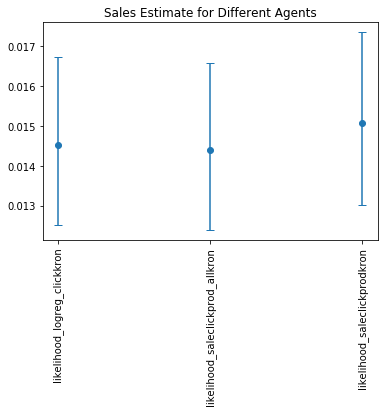

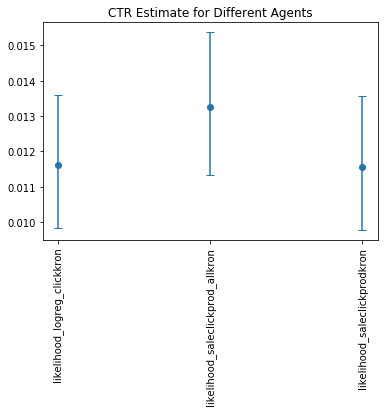

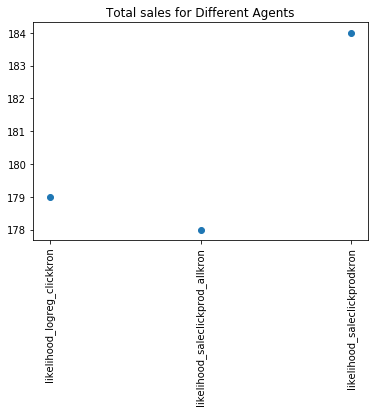

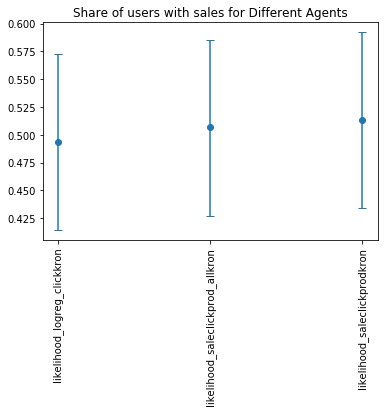

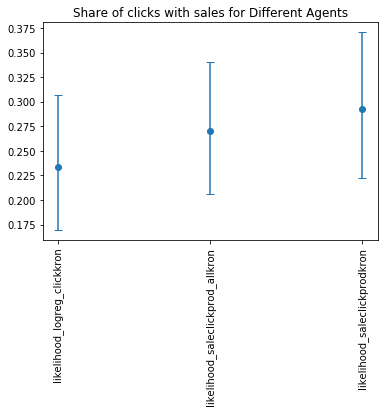

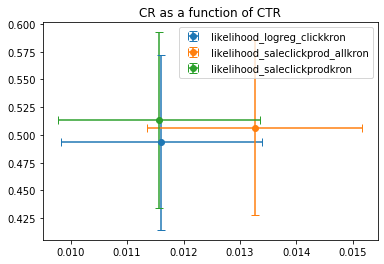

In [40]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)
   
# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [26]:
num_users_AB = 99

Kronecker features
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 99/99 [06:31<00:00,  3.96s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 99/99 [06:16<00:00,  3.80s/it]


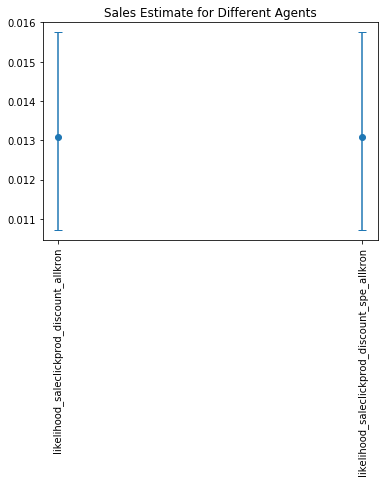

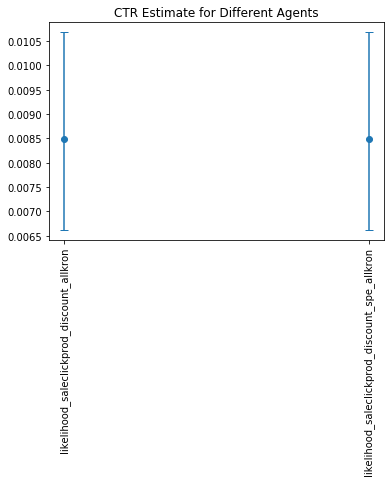

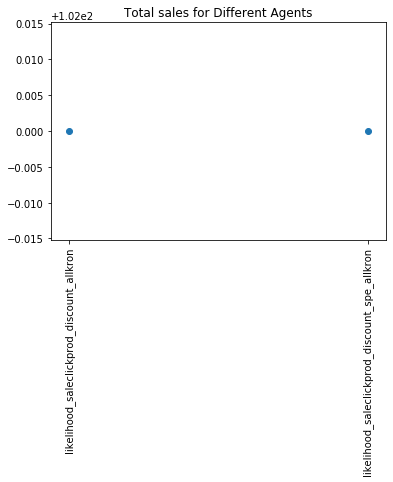

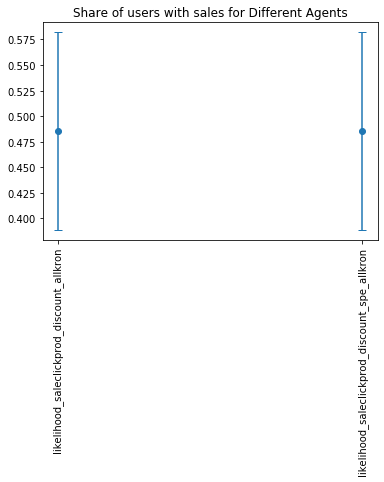

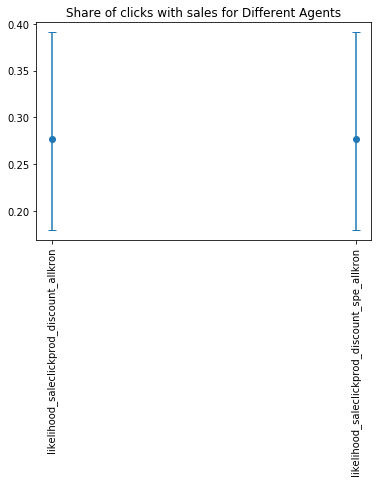

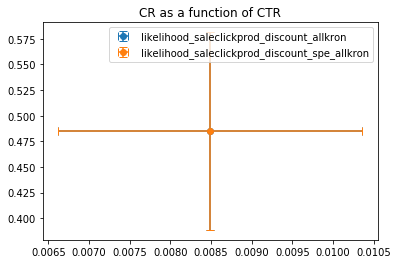

In [27]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)
    
# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [28]:
dico = res_dict[ 'rand1000_99_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_saleclickprod_discount_allkron
<IntegerArray>
[2, 6, 1, 7, 0, 3, 4]
Length: 7, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[2, 6, 1, 7, 0, 3, 4]
Length: 7, dtype: UInt16


In [17]:
name_extension='kron'
res_dict = {}

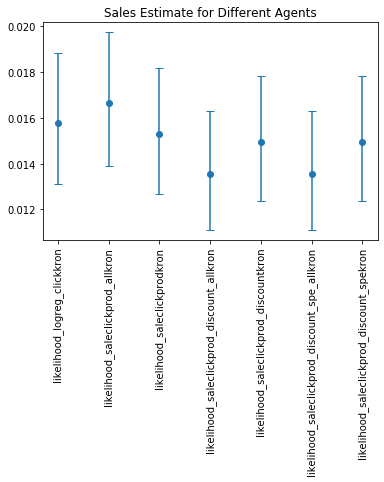

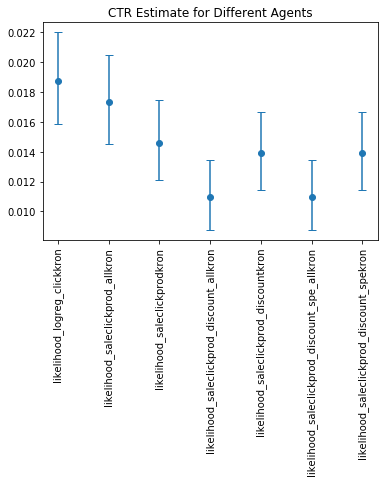

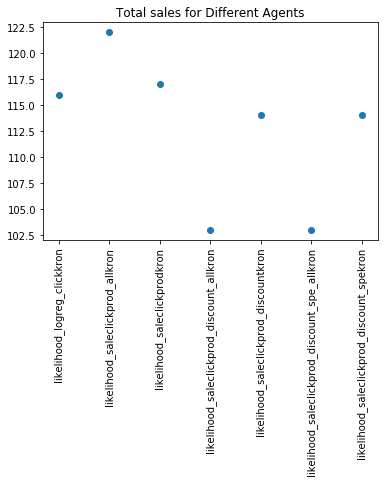

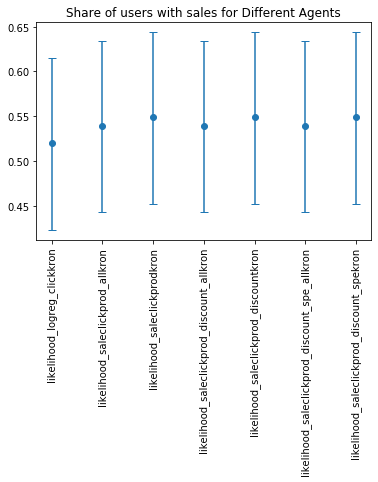

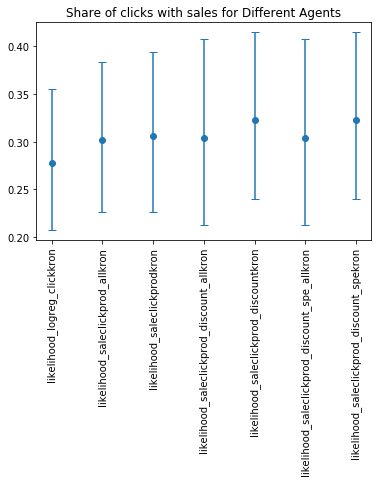

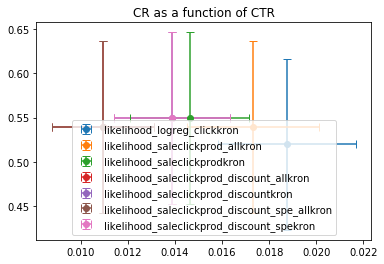

In [18]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [19]:
res_dict.keys()

dict_keys(['rand1000_100_v_sharekron'])

In [20]:
dico = res_dict[ 'rand1000_100_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[7, 9, 5, 4, 8, 3, 1, 6, 2]
Length: 9, dtype: UInt16
likelihood_saleclickprod_allkron
<IntegerArray>
[7, 9, 0, 5, 4, 3, 1, 8, 2]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[9, 5, 1, 7, 4, 3, 0, 2]
Length: 8, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[9, 5, 1, 7, 4, 3, 0, 2]
Length: 8, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[9, 5, 1, 7, 4, 3, 0, 2]
Length: 8, dtype: UInt16


In [23]:
import numpy as np
# from numba import njit
from numpy.random.mtrand import RandomState
from sklearn.linear_model import LogisticRegression
# import pandas as pd
# from copy import deepcopy
# from scipy.stats.distributions import beta
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# from torch.autograd import Variable
# from recogym.util import FullBatchLBFGS
import pandas as pd

# from ..envs.configuration import Configuration
# from ..envs.reco_env_v1_sale import env_1_args, ff, sig
from recogym.agents.abstract import Agent
# from recogym.envs.reco_env_v1_sale import RecoEnv1Sale

from recogym.agents import FeatureProvider



In [29]:
def sig(x):
    return 1.0 / (1.0 + np.exp(-x))

In [49]:
class SaleProductLikelihoodAgent(Agent):
    def __init__(self, feature_provider_list, reward_provider_list, discounts, discounts_with_action=True, 
                 kronecker_features = False, epsilon_greedy = False, epsilon = 0.3, seed=43):
        self.feature_provider_list = feature_provider_list
        self.reward_provider_list = reward_provider_list
        self.discounts = np.array(discounts) # list that indicates which model is used to which other model
        assert len(self.feature_provider_list) == len(self.reward_provider_list)
        self.random_state = RandomState(seed)
        self.models = [] # each model will correspond to a fitted logistic regression
        self.discounts_with_action = discounts_with_action
        self.kronecker_features = kronecker_features
        self.epsilon_greedy = epsilon_greedy
        self.epsilon = epsilon
        # self.cr = []
        self.num_models = len(self.reward_provider_list)
        # Keep information about the model
        self.info = {'Name':'','Other':[]}
        # Indices of models used to discount other models
        self.index_discount = np.where(self.discounts != 0)[0]
        # Indices of discounted models
        self.index_discounted = self.index_discount + self.discounts[self.index_discount]
        self.logged_observation = {'t': [],'u': [], 'z': [],'v': [], 'a': [],
                                   'c': [],'r': [],'ps': [], 'ps-a': []}
        
    @property
    def num_products(self):
        return self.feature_provider_list[0].config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) + self.num_products)
        # dummy variables
        features[:len(user_state)] = user_state
        features[int(len(user_state) + action)] = 1
        return features
    
    def _create_features_kronecker(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        # perform kronecker product directly on the flattened version of the features matrix
        features[action*len(user_state):(action+1)*len(user_state)] = user_state
        return features
    
    def train(self, logs):
        # Train all models
        for i in range(self.num_models):
            # Build training data
            feature_provider = self.feature_provider_list[i]
            reward_provider = self.reward_provider_list[i]
            user_states, actions, rewards, proba_actions, info = build_train_data(logs, 
                                                                            feature_provider, 
                                                                            reward_provider)
            self.info["Other"].append(info)
            # Keep info
            self.info["Name"]+= "Discounted" if i in self.index_discounted else ""
            self.info["Name"]+= "Discount" if i in self.index_discount else ""
            self.info["Name"]+= info["Name"]+"_"
            
            # Convert rewards to binary rewards
            rewards = (rewards > 0)*1
            
            # Keep track of conversion rate
            # self.cr.append(sum(rewards)/len(rewards))
            
            # Build features 
            if (self.discounts[i] == 0) or self.discounts_with_action :
                # Include action         
                if self.kronecker_features == False:   
                    actions_onehot = np.zeros((len(actions), self.num_products))
                    actions_onehot[np.arange(len(actions)),actions] = 1
                    
                    features = np.hstack([
                        user_states,
                        actions_onehot
                    ])
                else :
                    features = np.array([self._create_features_kronecker(user_states[i],
                                                                    actions[i]) 
                                         for i in range(len(actions))])
                
            else :
                # Models used as discounts don't use actions
                features = user_states
                    
                
            # Fit logistic regression and save model
            if len(features) > 0 :
                model = LogisticRegression(solver='lbfgs', max_iter=5000)
                model.fit(features, rewards)
            else :
                model = None
                
            self.models.append(model)
    
    def _score_products(self, user_state, model):
        
        if self.kronecker_features == False:
            all_action_features = np.array([self._create_features(user_state,action)
                                            for action in range(self.num_products)])
        else :
            all_action_features = np.array([self._create_features_kronecker(user_state,action)
                                            for action in range(self.num_products)])
        return model.predict_proba(all_action_features)[:, 1]
    
    def observation_to_log(self,observation):
        data = self.logged_observation
        
        def _store_organic(observation):
            assert (observation is not None)
            assert (observation.sessions() is not None)
            for session in observation.sessions():
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('organic' if session['z']=='pageview' else 'sale') 
                data['v'].append(session['v'])
                data['a'].append(None)
                data['c'].append(None)
                data['r'].append(None) ##H
                data['ps'].append(None)
                data['ps-a'].append(None)

        def _store_clicks(observation):
            assert (observation is not None)
            assert (observation.click is not None)
            for session in observation.click:
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('bandit') 
                data['v'].append(None)
                data['a'].append(session['a'])
                data['c'].append(session['c'])
                data['r'].append(None) 
                data['ps'].append(None)
                data['ps-a'].append(None)

        _store_organic(observation)
        _store_clicks(observation)
        self.logged_observation = data
        
        df = pd.DataFrame(data)
        df.sort_values('t')
        return df
        
    
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        if (self.epsilon_greedy == True) & (np.random.rand() < self.epsilon) : 
            print("Explore")
            action = np.random.randint(self.num_products())
            
        else :
            logged_observation = self.observation_to_log(observation)
            # Initialize the scores as 1
            score = np.ones(self.num_products)
            
            for i in range(len(self.index_discounted)):
                ## main (discounted) model 
                feature_provider = self.feature_provider_list[self.index_discounted[i]]
                feature_provider.observe(logged_observation) 
                user_state = feature_provider.features()
                before_discount = self._score_products(user_state, 
                                                       self.models[self.index_discounted[i]])
                
                ## model used as discount
                feature_provider = self.feature_provider_list[self.index_discount[i]]
                feature_provider.observe(logged_observation)      
                user_state = feature_provider.features()
                user_state = user_state.reshape(1, -1)
                if self.models[self.index_discount[i]] is not None :
                    if self.discounts_with_action == False :
                        discount_val = self.models[self.index_discount[i]].predict_proba(user_state)
                        discount_val = discount_val[0][1]
                    else :
                        discount_val = self._score_products(user_state,
                                                            self.models[self.index_discount[i]])
                else :
                    print("No discount")
                    discount_val = np.zeros(before_discount.shape)
                    
                ## Combine the two models
#                 # Clip discounted score to avoid negatives
#                 after_discount = np.clip(before_discount - discount_val,a_min=0,a_max=1)
                after_discount = before_discount - discount_val
                if after_discount.any() < 0 :
                    print("apply sigmoid")
                    after_discount = sig(after_discount)
                score = score*after_discount
            
            for i in set(range(self.num_models))-set.union(set(self.index_discount),set(self.index_discounted)):
                feature_provider = self.feature_provider_list[i]
                feature_provider.observe(logged_observation)      
                user_state = feature_provider.features()
                score = score*self._score_products(user_state, self.models[i])
            
            action = np.argmax(score)
        
        ps = 1.0
        all_ps = np.zeros(self.num_products)
        all_ps[action] = 1.0        
        
        if done :
            self.reset()
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        for i in range(self.num_models):
            self.feature_provider_list[i].reset()  
            
        self.logged_observation = {'t': [],'u': [], 'z': [],'v': [], 'a': [],
                                   'c': [],'r': [],'ps': [], 'ps-a': []}





In [ ]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

### no clipping : then not only zero, but very poor results

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [02:03<00:00,  1.13s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:06<00:00,  1.70s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:25<00:00,  1.87s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:37<00:00,  1.98s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [04:16<00:00,  2.33s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [05:27<00:00,  2.97s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

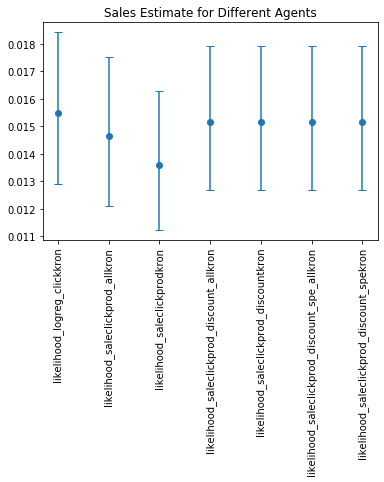

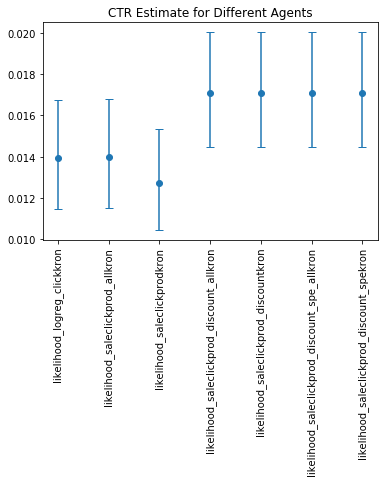

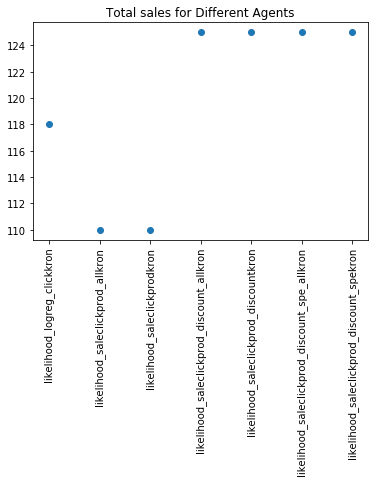

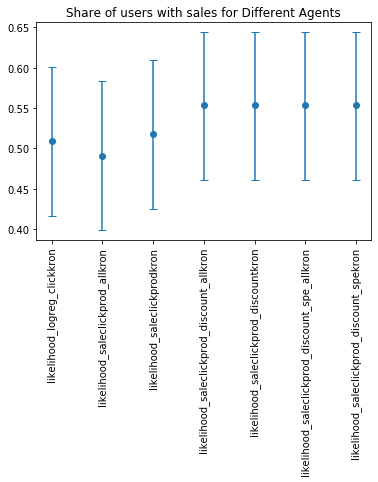

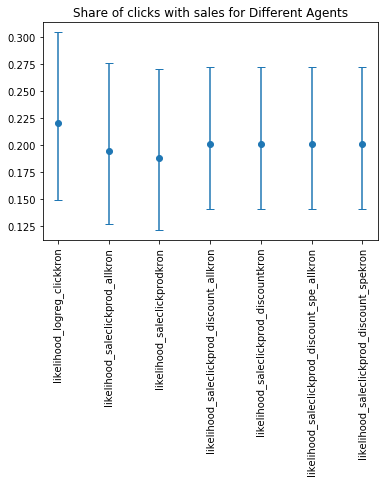

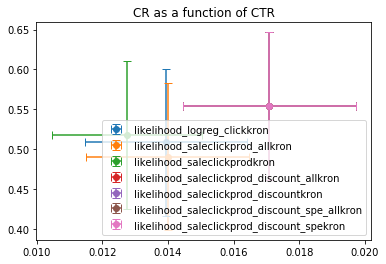

In [45]:
# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [46]:
dico = res_dict[ 'rand100_110_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[7, 8, 5, 2, 3, 0, 6, 9, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprod_allkron
<IntegerArray>
[7, 9, 5, 2, 8, 0, 3, 6, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[7, 4, 5, 8, 0, 6, 2, 3, 9]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [01:48<00:00,  1.21s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:19<00:00,  1.55s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:43<00:00,  1.81s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:33<00:00,  1.71s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:32<00:00,  1.70s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:35<00:00,  1.73s/it]


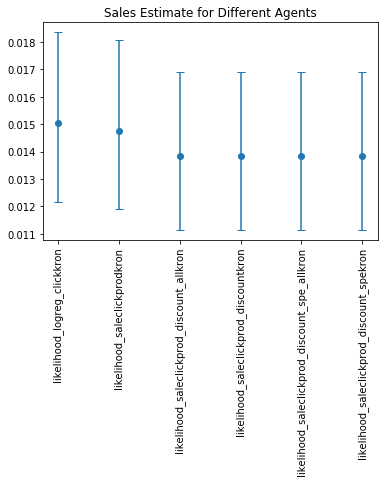

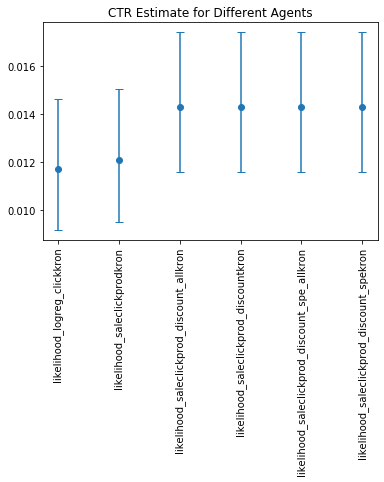

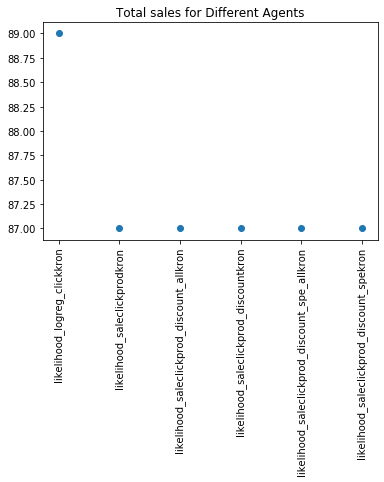

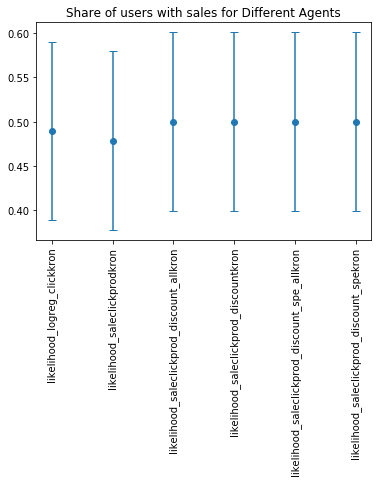

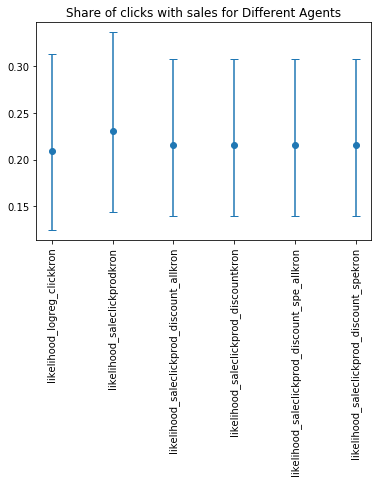

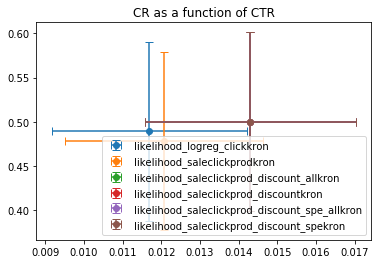

In [37]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [38]:
dico = res_dict[ 'rand100_90_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[4, 5, 8, 0, 7, 3, 6, 9, 2]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[4, 7, 0, 8, 5, 2, 9, 3, 6]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Kronecker features
Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.39s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.56s/it]


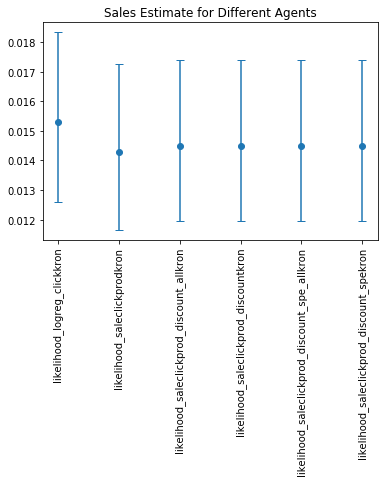

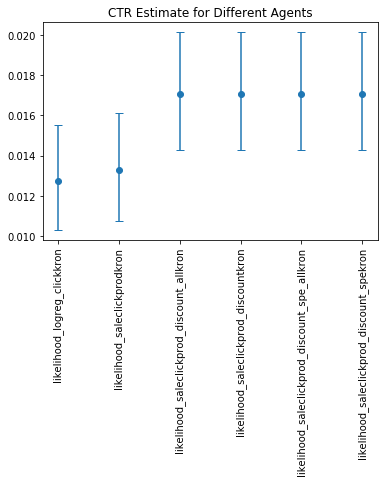

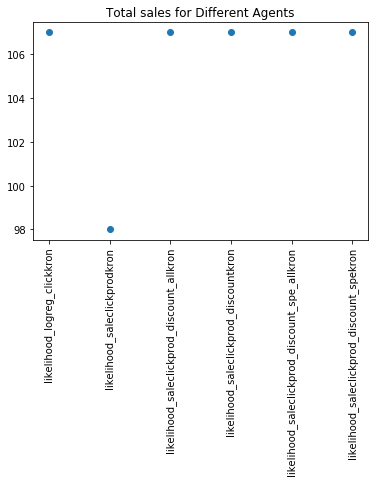

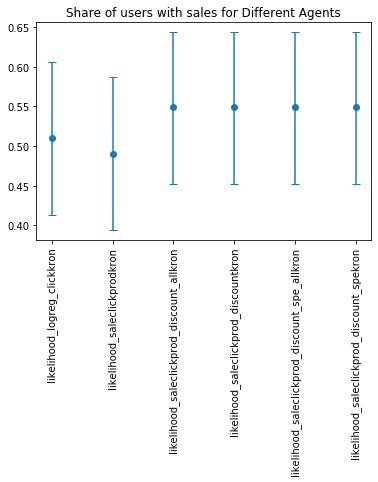

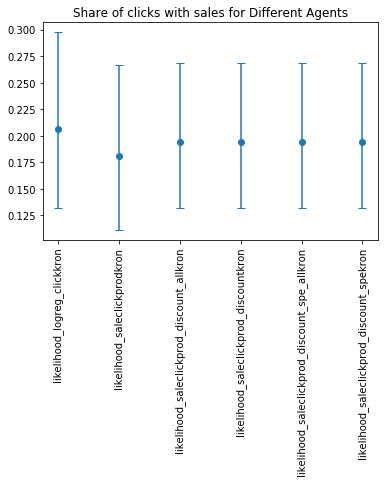

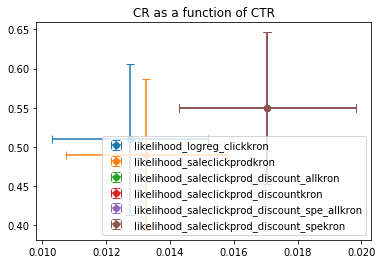

In [30]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [31]:
dico = res_dict[ 'rand100_100_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[3, 8, 5, 2, 7, 0, 6, 9, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[9, 5, 2, 7, 8, 0, 3, 6, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


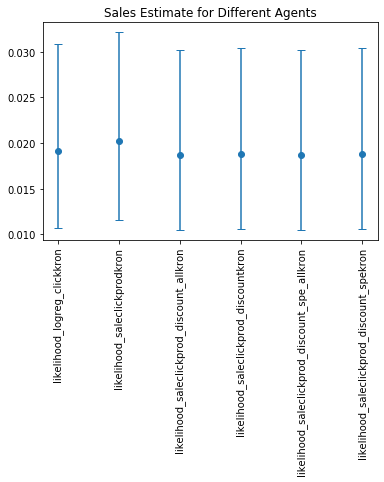

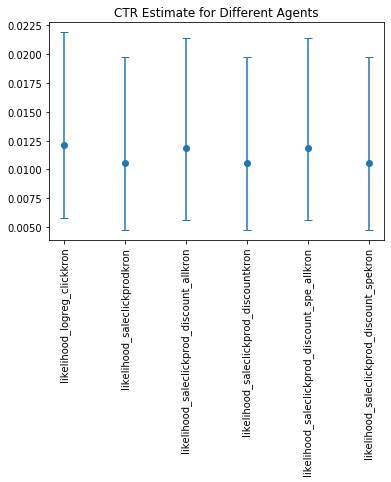

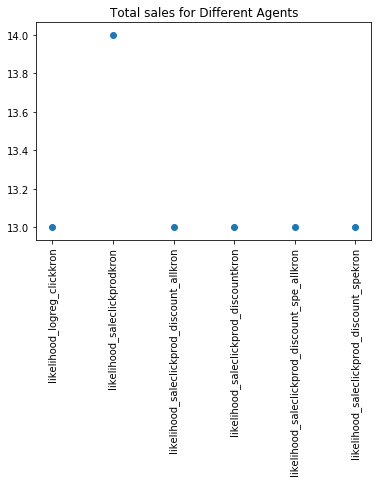

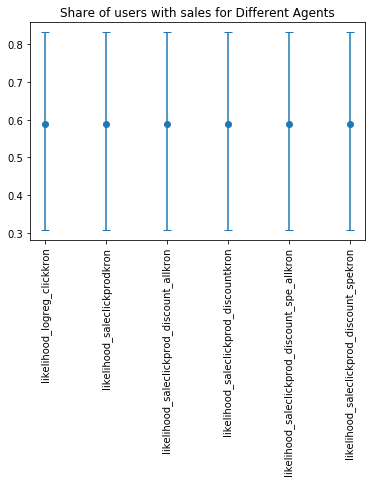

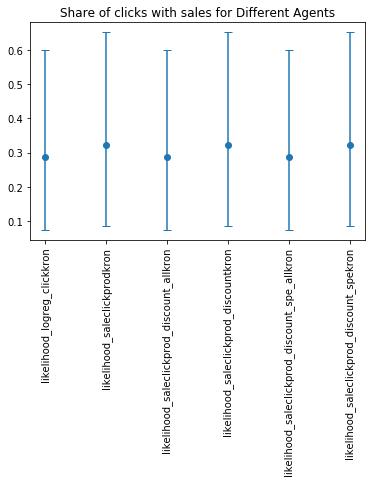

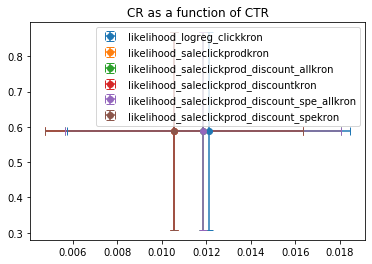

In [43]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [47]:
dico = res_dict[ 'rand1000_10_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[5]
Length: 1, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[4, 9, 5]
Length: 3, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[1, 9, 5, 7]
Length: 4, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[1, 9, 5, 7]
Length: 4, dtype: UInt16


In [ ]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+name_extension+".pkl","wb"))

### 1000 users in training and AB test

In [7]:
res_dict={}
name_extension='kron'

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [40:33<00:00,  2.43s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [51:38<00:00,  3.10s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:04:52<00:00,  3.89s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:57<00:00,  3.96s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [56:22<00:00,  3.38s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:31<00:00,  4.17s/it]


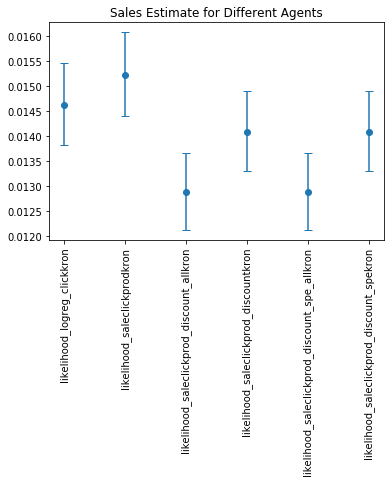

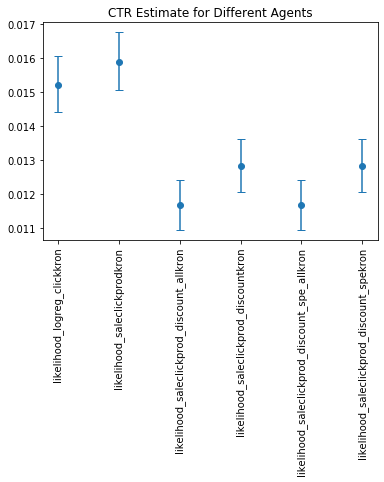

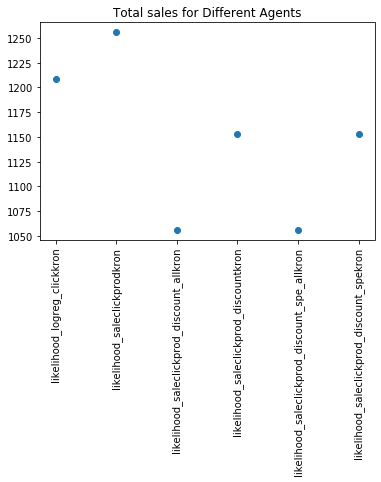

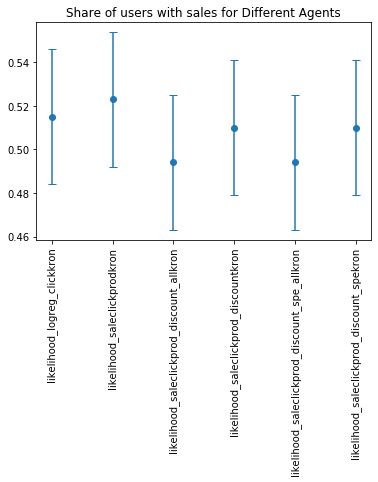

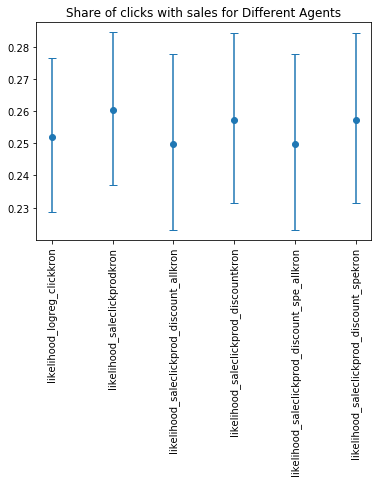

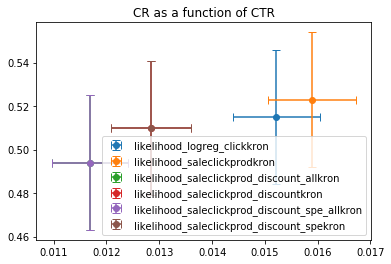

In [10]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [50:37<00:00,  3.04s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:08:17<00:00,  4.10s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:27<00:00,  3.51s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:19<00:00,  3.50s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:11<00:00,  3.43s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:00<00:00,  3.48s/it]


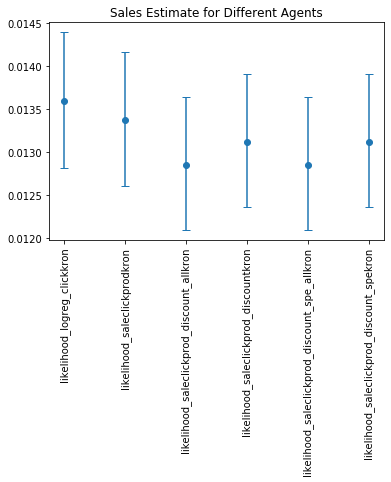

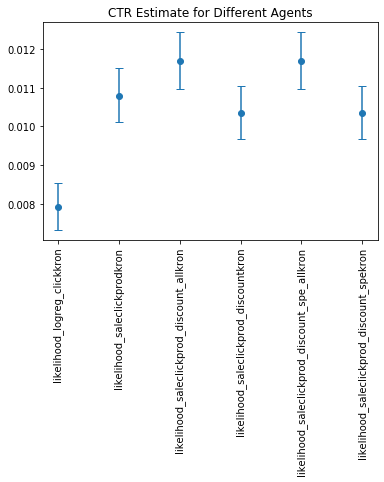

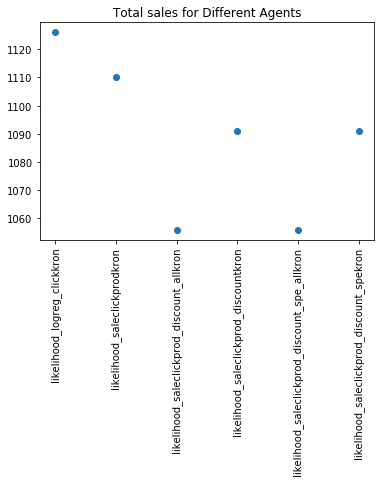

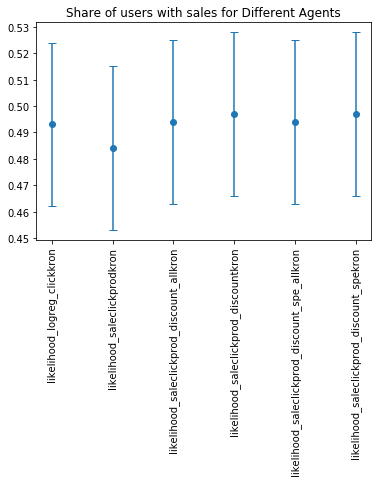

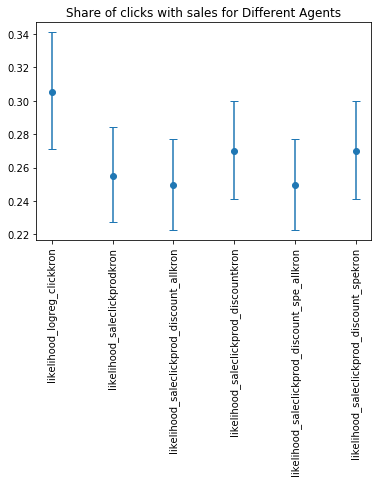

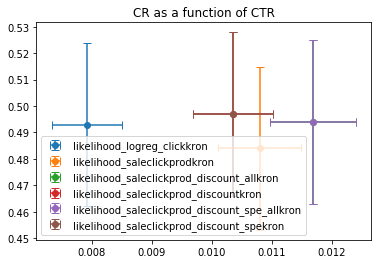

In [11]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.50it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.33it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [36:37<00:00,  2.20s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [48:44<00:00,  2.92s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:42<00:00,  3.46s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:25<00:00,  3.45s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

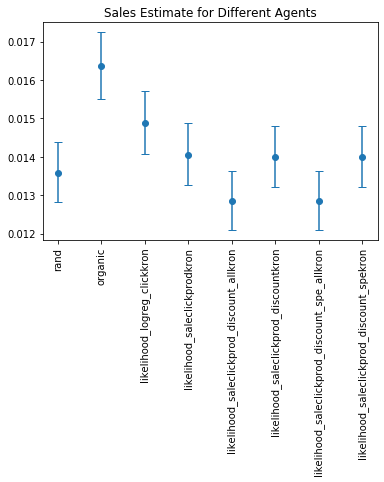

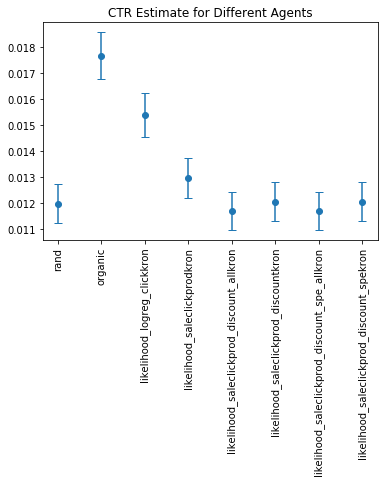

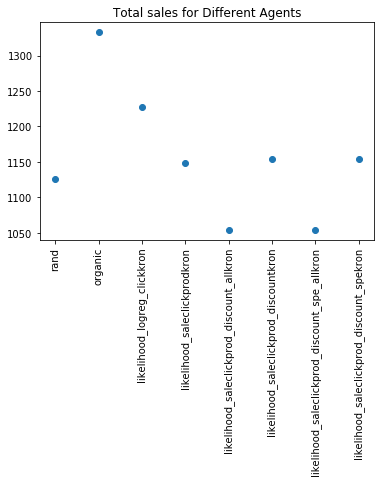

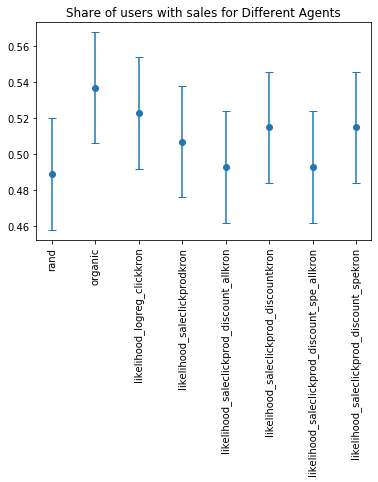

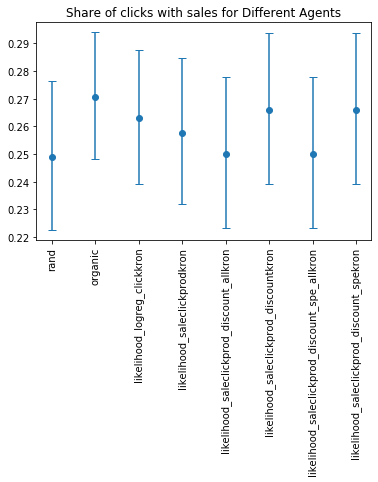

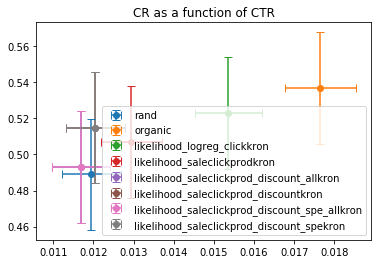

In [12]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [13]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+name_extension+".pkl","wb"))